# Sparkify Customer Churn Prediction

Sparkify is a hypothetical music streaming service app, similar to Spotify, created by Udacity for the purpose of analyzing customer usage in this space.  The dataset we're working with is a timeseries set that documents user's actions on the app.  The goal of this analysis is to, by using the transactional dataset, determine which customers are at risk of cancelling their service with the app.  

The goal of this analysis is to predict customer churn on the Sparkify music app.  Churn, in this case, will be defined as a customer cancelling their subscription service.  We will use Apache Spark's ETL and ML libraries to create different ML models on the user data to predict whether or not a user is at risk of cancellation by first collection key features of each user and constructing an input dataset where each row is one user.  Features that will be used will be related to their aggregated usage on different pages, times of day, distinct songs/artists listened to, and overall time on the app.  We expect that the results will be superior to the naive solution (assuming no user churns).

# 1. Import Data and Packages

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, MaxAbsScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, GBTClassifier, GBTClassificationModel,\
    RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

import numpy as np
import pandas as pd
from time import time
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

sparkify_data = 'mini_sparkify_event_data.json'

Load the dataset into memory from the .json file.

In [2]:
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

Let's take a quick peek at the dataset.

# 2. Exploration

## 2a. Data Cleaning

In [3]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

Let's check the stats on the `userId` and `sessionId` columns to assure there's not any weird inputs.

In [5]:
df.describe('userId','sessionId').show()

+-------+-----------------+-----------------+
|summary|           userId|        sessionId|
+-------+-----------------+-----------------+
|  count|           286500|           286500|
|   mean|59682.02278593872|1041.526554973822|
| stddev|109091.9499991047|726.7762634630741|
|    min|                 |                1|
|    max|               99|             2474|
+-------+-----------------+-----------------+



The metrics above seem to all be numeric except for the min of `userId`, let's investigate.

Count the total number of entries and count the number of nan values in each column.

In [6]:
df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



Here we can see that the fields with 58392 missing values are not important to define churn.  The fields missing only 8346 values are also not important to define churn.  Therefore, we will not filter the data set by null values.

We can look also for empty strings below.

In [7]:
df.select([F.count(F.when(F.col(c) == "", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



We can see that the only field with empty strings is the `userId`.  This is important to defining churn so we'll further investigate.

In [8]:
empty_userId_cnt = df.select([F.count(F.when(F.col(c) == "", c)).alias(c) for c in ['userId']]).collect()[0]['userId']
total_entries_cnt = df.count()
print('About {}% of userId entries are the empty string.'.format(round(empty_userId_cnt / total_entries_cnt * 100, 2)))

About 2.91% of userId entries are the empty string.


Let's take a look at what some of these entries look like.

In [9]:
df.select('*').where(F.col('userId') == "").limit(2).show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+



It looks like the user is logged out when there isn't any `userId`, let's further examine.

In [10]:
df.select('auth','page').where(F.col('userId') == "").dropDuplicates().show()

+----------+-------------------+
|      auth|               page|
+----------+-------------------+
|Logged Out|               Home|
|     Guest|           Register|
|Logged Out|              Error|
|     Guest|              About|
|     Guest|              Error|
|Logged Out|              Login|
|Logged Out|               Help|
|     Guest|Submit Registration|
|Logged Out|              About|
|     Guest|               Help|
|     Guest|               Home|
+----------+-------------------+



It's evident that an entry without a `userId` the user is either logged out or a guest.  We're not interested in churn for customers that aren't subscribed or logged into the app, therefore we'll drop these rows.

In [11]:
df = df.where(F.col('userId') != "")

Let's reinvestigate the statistics on `userId` and `sessionId`.

In [12]:
df.describe('userId','sessionId').show()

+-------+-----------------+------------------+
|summary|           userId|         sessionId|
+-------+-----------------+------------------+
|  count|           278154|            278154|
|   mean|59682.02278593872|1042.5616241362698|
| stddev|109091.9499991047| 726.5010362219813|
|    min|               10|                 1|
|    max|               99|              2474|
+-------+-----------------+------------------+



Everything's numeric, let's proceed to convert the timestamps into a datetime format and create a duration column to show how long since the user registered in seconds.

In [13]:
df = df.withColumn('registration', F.to_timestamp(F.col('registration')/1000))\
  .withColumn('ts', F.to_timestamp(F.col('ts')/1000))\
  .withColumn('userDurationInHours', (F.col('ts').cast('long') - F.col('registration').cast('long'))/3600)

Let's create a field that highlights the hour of the day that the user made the action:

In [14]:
hour = F.udf(lambda x: x.hour, IntegerType())
df = df.withColumn('hourOfDay', hour(F.col('ts')))

## 2b. Exploratory Data Analysis

### i. Define Churn

Let's investigate the different pages users have explored.

In [15]:
df.select('page').dropDuplicates().orderBy('page').show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



After some investigation its seems that users will visit the `page` 'Submit Downgrade' and then either remain in a paid or free service.  When a user visits a 'Cancellation Confirmation' it seems to be the last page that they visit.  

__Let's define churn__ as when a user visits `page` = 'Cancellation Confirmation', which signifies the end of the user's journey with sparkify.  Below illustrates how each user only visits `page` 'Cancellation Confirmation' no more than 1 time.

In [16]:
df.where(F.col('page') == 'Cancellation Confirmation')\
    .groupby('userId').count().alias('count').filter(F.col('count') > 1).collect()

[]

We're only interested in the entries before a user Cancel's so to assure this is the case we build a function to split out phases before and after a churn event.  We noticed that there are instances where 'Cancellation Confirmation' `ts` matches that of cancelled.  In order to assure 'Cancellation Confirmation' occurred after 'Cancel', we add 1 second to the `ts` for 'Cancellation Confirmation'.

In [17]:
df = df.withColumn('ts', F.when(F.col('page') == 'Cancellation Confirmation', \
            F.col('ts') + F.expr('INTERVAL 1 seconds')).otherwise(F.col('ts')))

In [18]:
flag_churn_event = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churned', flag_churn_event(F.col('page')))

In [19]:
window = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.currentRow)
df = df.withColumn('phase', F.sum('churned').over(window))

Create a df holding the labels of the userId and if they've churned or not.

In [20]:
df_labels = df.groupBy('userId').agg(F.max('churned').alias('customer_churn_flag'))

In [21]:
df = df.join(df_labels, df.userId == df_labels.userId, 'left').select(df['*'], df_labels['customer_churn_flag'])

For the Analysis we're interested in analyzing phase 0 rows for all users and creating features that can predict customer churn.

### ii. Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Let's explore the data set based on churned vs. not churned users.  We know that fields specific to the user's identity are not going to aid in understanding the problem better so let's drop those fields now.  We'll also drop `auth`, and `userAgent` since they won't help in determining churn either.  That leaves us with the following columns:

- artist = song's artist
- gender = if user is male or female
- itemInSession = item number in the user session
- level = paid or free user
- song = name of song played
- page = page user is currently on
- registration = seems to be the timestamp when the user registered
- sessionId = sessionId of the user, seems to be distinct throughout userIds
- status = http return status, 200 = successful, 307 = redirect, 404 = page not found
- userId = Unique userId

In [22]:
df = df.drop('firstName', 'lastName', 'location', 'userAgent', 'auth', 'method', 'length')

In [23]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: timestamp (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- userId: string (nullable = true)
 |-- userDurationInHours: double (nullable = true)
 |-- hourOfDay: integer (nullable = true)
 |-- churned: integer (nullable = true)
 |-- phase: long (nullable = true)
 |-- customer_churn_flag: integer (nullable = true)



Customers that churned by `gender`:

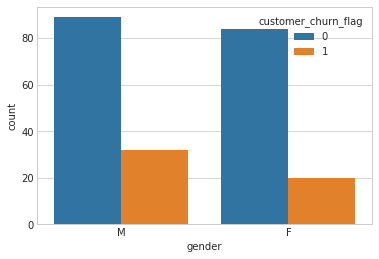

In [24]:
pd_gender = df.select(F.col('gender'), F.col('userId'), F.col('customer_churn_flag')).dropDuplicates().toPandas()
sns.countplot(x='gender', hue='customer_churn_flag', data=pd_gender);

Customers that churned by `level`:

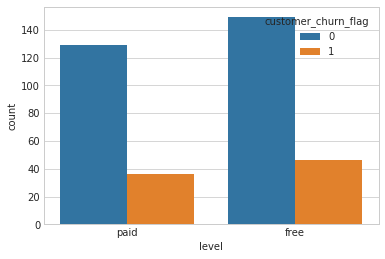

In [25]:
pd_level = df.select(F.col('level'), F.col('userId'), F.col('customer_churn_flag')).dropDuplicates().toPandas()
sns.countplot(x='level', hue='customer_churn_flag', data=pd_level);

Average broken page views per `userId` between churned and nonchurned customers to see if churned customers see more broken pages than nonchurned:

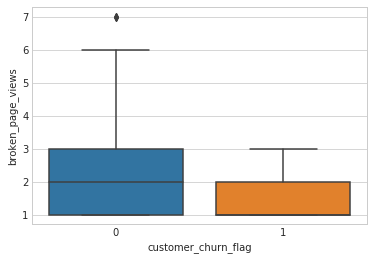

In [26]:
pd_status = df.filter(F.col('status') == '404').groupBy(F.col('userId'), F.col('customer_churn_flag'))\
    .agg(F.count(F.col('status')).alias('broken_page_views')).orderBy(F.col('userId')).toPandas()
sns.boxplot(x='customer_churn_flag', y='broken_page_views', data=pd_status);

Check the average time from registration to churned user and compare to average max time from registration of an unchurned user to see if there's much of a difference:

In [27]:
df.where(F.col('churned') == 1).groupBy(F.col('customer_churn_flag')).agg(F.mean(F.col('userDurationInHours'))).show()

+-------------------+------------------------+
|customer_churn_flag|avg(userDurationInHours)|
+-------------------+------------------------+
|                  1|       1375.343830128205|
+-------------------+------------------------+



In [28]:
df.where(F.col('customer_churn_flag') == 0).groupBy(F.col('userId')).agg(F.max(F.col('userDurationInHours')).alias('maxHours'))\
    .groupBy().agg(F.mean('maxHours')).show()

+------------------+
|     avg(maxHours)|
+------------------+
|2078.8948651252413|
+------------------+



The average time from `registration` for a churned user is roughly half the max time of an unchurned user.

Examine the difference in the number of unique `artist` a user has listened to between churned and unchurned users:

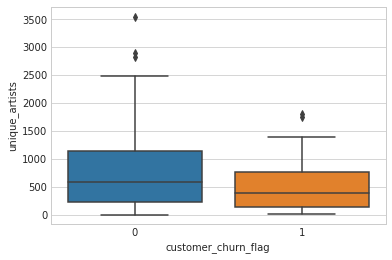

In [29]:
pd_artists = df.groupBy(F.col('customer_churn_flag'), F.col('userId'))\
    .agg(F.countDistinct(F.col('artist')).alias('unique_artists')).toPandas()
sns.boxplot(x='customer_churn_flag', y='unique_artists', data=pd_artists);

Unchurned users listen to significantly more unique `artist` than a churned user.  The same process will be used to look at unique `song`. 

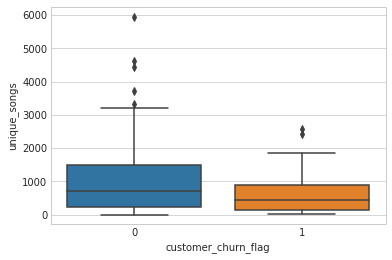

In [30]:
pd_songs = df.groupBy(F.col('customer_churn_flag'), F.col('userId'))\
    .agg(F.countDistinct(F.col('song')).alias('unique_songs')).toPandas()
sns.boxplot(x='customer_churn_flag', y='unique_songs', data=pd_songs);

Again, it can be seen that there is a noticeable difference in the number of unique `song` listened to by a churned v. unchurned user.

Let's explore average session `itemInSession` and length per session per user:

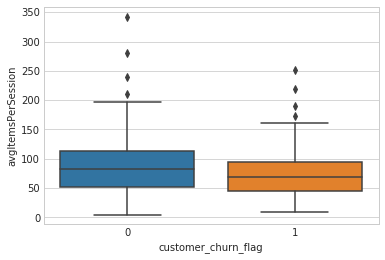

In [31]:
pd_items = df.groupBy(F.col('customer_churn_flag'), F.col('userId'), F.col('sessionId'))\
    .agg(F.max(F.col('itemInSession')).alias('itemsPerSession'))\
    .groupBy(F.col('customer_churn_flag'), F.col('userId'))\
    .agg(F.mean(F.col('itemsPerSession')).alias('avgItemsPerSession')).toPandas()
sns.boxplot(x='customer_churn_flag', y='avgItemsPerSession', data=pd_items);

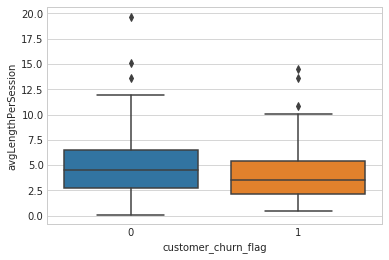

In [32]:
pd_length = df.groupBy(F.col('customer_churn_flag'), F.col('userId'), F.col('sessionId'))\
    .agg(((F.max(F.col('ts').cast('long')) - F.min(F.col('ts').cast('long'))) / 3600).alias('lengthPerSession'))\
    .groupBy(F.col('customer_churn_flag'), F.col('userId'))\
    .agg(F.mean(F.col('lengthPerSession')).alias('avgLengthPerSession')).toPandas()
sns.boxplot(x='customer_churn_flag', y='avgLengthPerSession', data=pd_length);

There's a considerable difference between the items in session and the session length for churned vs unchurned customers.  Let's now examine the average times visiting each page between cohorts:

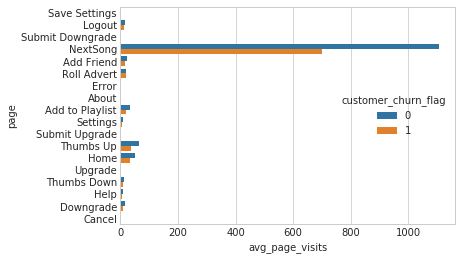

In [33]:
pd_page_views = df.filter(~F.col('page').isin(['Cancellation Confirmation']))\
    .groupBy(F.col('customer_churn_flag'), F.col('userId'), F.col('page'))\
    .agg(F.count(F.col('page')).alias('page_visits'))\
    .groupBy(F.col('customer_churn_flag'), F.col('page'))\
    .agg(F.mean(F.col('page_visits')).alias('avg_page_visits')).toPandas()
sns.barplot(x='avg_page_visits', y='page', hue='customer_churn_flag', data=pd_page_views);

A double click onto all pages less `NextPage` gives us:

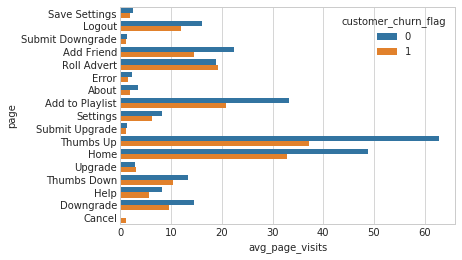

In [34]:
pd_page_views = df.filter(~F.col('page').isin(['Cancellation Confirmation','NextSong']))\
    .groupBy(F.col('customer_churn_flag'), F.col('userId'), F.col('page'))\
    .agg(F.count(F.col('page')).alias('page_visits'))\
    .groupBy(F.col('customer_churn_flag'), F.col('page'))\
    .agg(F.mean(F.col('page_visits')).alias('avg_page_visits')).toPandas()
sns.barplot(x='avg_page_visits', y='page', hue='customer_churn_flag', data=pd_page_views);

Investigate the daily patterns of listening to music:

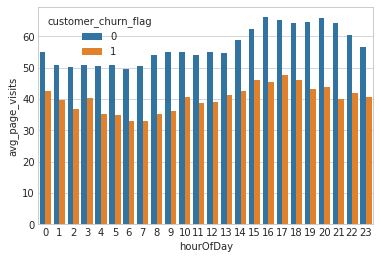

In [35]:
pd_hour_of_day = df.filter(F.col('page').isin(['NextSong']))\
    .groupBy(F.col('customer_churn_flag'), F.col('userId'), F.col('hourOfDay'))\
    .agg(F.count(F.col('page')).alias('page_visits'))\
    .groupBy(F.col('customer_churn_flag'), F.col('hourOfDay'))\
    .agg(F.mean(F.col('page_visits')).alias('avg_page_visits')).toPandas()
sns.barplot(x='hourOfDay', y='avg_page_visits', hue='customer_churn_flag', data=pd_hour_of_day);

# 3. Feature Engineering

Now that the data has been explored we can build the dataset as an input to the ML model.  We'll redo some steps above to group the feature engineering process and complie for future scalability.

## 3a. Import and Clean Data

In [36]:
df = spark.read.json(sparkify_data)
df.persist()

# Drop empty columns
df = df.where(F.col('userId') != "")

# Change the date columns to a timestamp format and create user duration measurements.
df = df.withColumn('registration', F.to_timestamp(F.col('registration')/1000))\
  .withColumn('ts', F.to_timestamp(F.col('ts')/1000))\
  .withColumn('userDurationInHours', (F.col('ts').cast('long') - F.col('registration').cast('long'))/3600)

hour = F.udf(lambda x: x.hour, IntegerType())
df = df.withColumn('timeOfDay', 
                         F.when((hour(F.col('ts')) >= 1) & (hour(F.col('ts')) <= 7), 'earlyMorning')\
                        .otherwise(F.when((hour(F.col('ts')) >= 8) & (hour(F.col('ts')) <= 13), 'firstHalfWorkday')\
                        .otherwise(F.when((hour(F.col('ts')) >= 14) & (hour(F.col('ts')) <= 18), 'lastHalfWorkday')\
                        .otherwise(F.when((hour(F.col('ts')) >= 19) & (hour(F.col('ts')) <= 21), 'evening')\
                        .otherwise('latenite'))))
                  )

# Increment each cancellation event by 1 second to assure there's no matching timestamp with any other events 
# and that the cancellation step is the user's final step.
df = df.withColumn('ts', F.when(F.col('page') == 'Cancellation Confirmation',\
            F.col('ts') + F.expr('INTERVAL 1 seconds')).otherwise(F.col('ts')))

# Drop columns determined by exploration analysis above.
df = df.drop('firstName', 'lastName', 'location', 'userAgent', 'auth', 'method', 'length', 'registration')

# Churn will be defined as when the user submits a cancellation confirmation.
flag_churn_event = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churnEvent', flag_churn_event(F.col('page')))

window = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.currentRow)
df = df.withColumn('churnPhase', F.sum('churnEvent').over(window))

df_labels = df.groupBy('userId').agg(F.max('churnEvent').alias('customerChurnLabel'))

# Split the data into phases defined by churn event, 
# only analyze "before" events so to create a predictive model of customer churn.
df = df.filter(F.col('churnPhase') == 0).drop('churnPhase','churnEvent')

## 3b. Create User Features

The goal here is to create an input matrix for the ML model where each row represents 1 userId and each column is a feature based on the exploratory analysis above.  These will be performed by multiple groupBy segments followed by a join at the end.

### i. Aggregate Features

In [37]:
df_input_base = df.groupBy(F.col('userId')).agg(
        F.max(F.when(F.col('gender') == 'M', 1).otherwise(0)).alias('isMale'),
        F.sum(F.when(F.col('status') == '404', 1).otherwise(0)).cast('integer').alias('brokenPageViewCount'),
        F.max(F.round(F.col('userDurationInHours')).cast('integer')).alias('hoursSinceRegistration'),
        F.countDistinct(F.col('artist')).cast('integer').alias('distinctArtists'),
        F.countDistinct(F.col('song')).cast('integer').alias('distinctSongs')
    )

### ii. Last Seen User Level

In [38]:
df_level = df.select(F.col('userId'), F.col('ts'), F.col('level'))
user_final_level = F.udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df_level = df_level.withColumn('level', user_final_level('level').cast(IntegerType()))

In [39]:
w = Window.partitionBy('userId').orderBy(F.desc('ts'))
df_level = df_level.withColumn('timeRankDesc', F.row_number().over(w))
df_level = df_level.filter(F.col('timeRankDesc') == 1).drop('timeRankDesc', 'ts')

### iii. Average Items, Length per Session, & Number of Songs per Session

In [40]:
df_items_len_per_session = df.groupBy(F.col('userId'), F.col('sessionId'))\
    .agg(F.max(F.col('itemInSession')).alias('itemsPerSession'),
        ((F.max(F.col('ts').cast('long')) - F.min(F.col('ts').cast('long'))) / 3600).alias('hoursPerSession'),
        F.sum(F.when(F.col('page') == 'NextSong', 1).otherwise(0)).alias('numSongsPerSession'))\
    .groupBy(F.col('userId'))\
    .agg(F.mean(F.round(F.col('itemsPerSession'))).cast('integer').alias('avgItemsPerSession'),
        F.mean(F.round(F.col('hoursPerSession'))).cast('integer').alias('avgHoursPerSession'),
        F.mean(F.round(F.col('numSongsPerSession'))).cast('integer').alias('avgNumSongsPerSession')
        )

### iv. Page Views


In [41]:
df_page_views = df.filter(~F.col('page').isin(['Cancellation Confirmation']))\
    .groupBy(F.col('userId'))\
    .pivot('page')\
    .agg(F.count(F.col('page')).cast('integer'))\
    .na.fill(value=0)

### v. Time of Day


In [42]:
df_time_of_day = df.filter(F.col('page').isin(['NextSong']))\
    .groupBy(F.col('userId'))\
    .pivot('timeOfDay')\
    .agg(F.count(F.col('page')).cast('integer').alias('pageVisits'))\
    .na.fill(value=0)

### vi. Joins


In [43]:
df_input = df_input_base.join(df_level, ['userId'])\
        .join(df_items_len_per_session, ['userId'])\
        .join(df_page_views, ['userId'])\
        .join(df_time_of_day, ['userId'])\
        .join(df_labels, ['userId'])

In [44]:
df = df_input.toPandas()

## 3c. Check feature correlation (multicollinearity)

Check collinearity of input features.

Determine highly correlated features to remove from the data set.

In [45]:
corr = df.corr()
max_corr_value = 0.90
cols_to_remove = [col for i, col in enumerate(corr.columns) if corr[col].iloc[i+1:].abs().max() > max_corr_value]
cols_to_keep = [col for col in df.columns if col not in cols_to_remove]
df = df[cols_to_keep]
print(cols_to_keep)

['userId', 'isMale', 'hoursSinceRegistration', 'level', 'avgNumSongsPerSession', 'About', 'Error', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Upgrade', 'lastHalfWorkday', 'latenite', 'customerChurnLabel']


Visualize correlation matrix for remaining features.

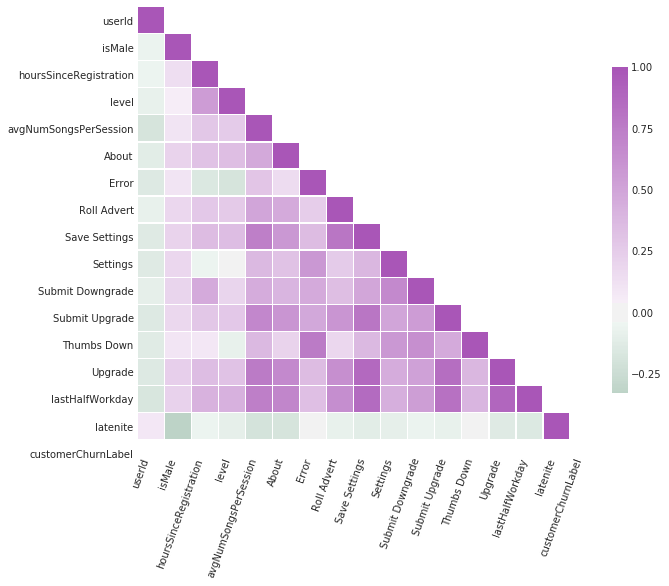

In [46]:
df_corr = df.corr()
df_corr = df_corr.where(np.tril(np.ones(df_corr.shape)).astype(np.bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
ax = sns.heatmap(
    df_corr, cmap=cmap, center=0,
    square=True, linewidths=.25, cbar_kws={"shrink": .60}, 
    xticklabels=df.columns,
    yticklabels=df.columns,
)
plt.xticks(rotation=70, ha='right', fontsize=10) 
plt.yticks(fontsize=10);

## 3d. Check & Remove Feature Skew

We check the input data for skew since the tail region may act as an outlier for the model and therefore adversely affect the model's performance, especially for regression-based models.

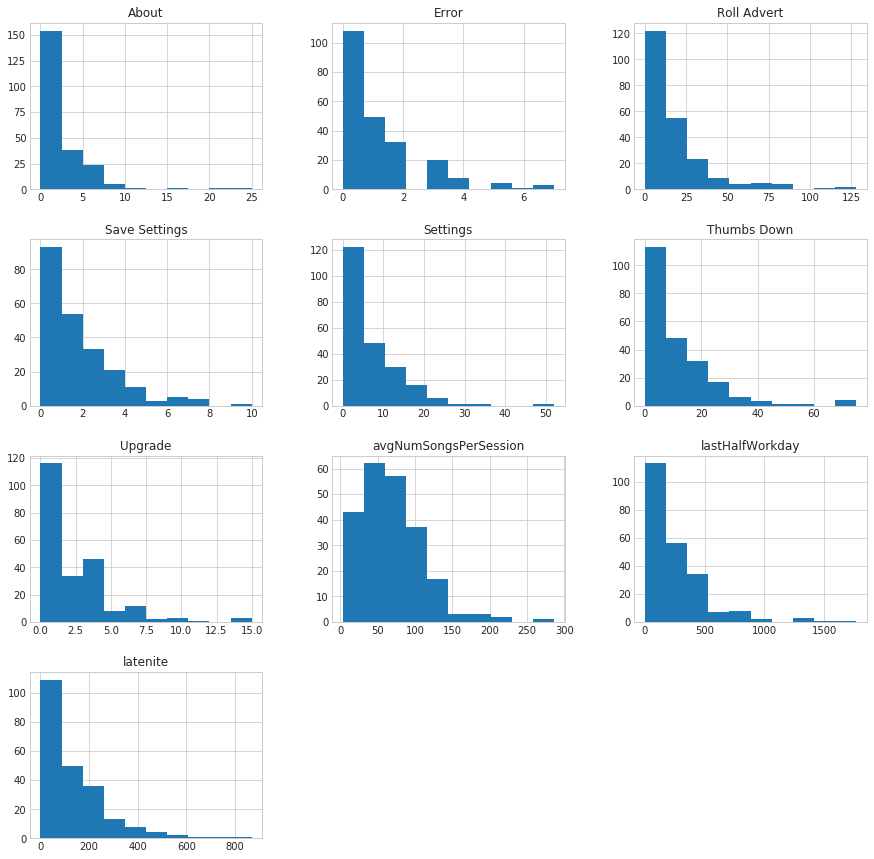

In [47]:
# Check skew on columns. Drop binary features, close to binary features, and those without much skew
exclude_cols = ['customerChurnLabel','userId','isMale','level', 'Cancel', 
                'Submit Downgrade', 'Submit Upgrade', 'hoursSinceRegistration']
col_to_log = [col for col in df.columns if col not in exclude_cols]
df[col_to_log].hist(figsize=(15,15));

Most inputs show a heavy right skew so we'll attempt to normalize these features below.  We'll use a log + 1 approach to account for the many 0 elements in the features.

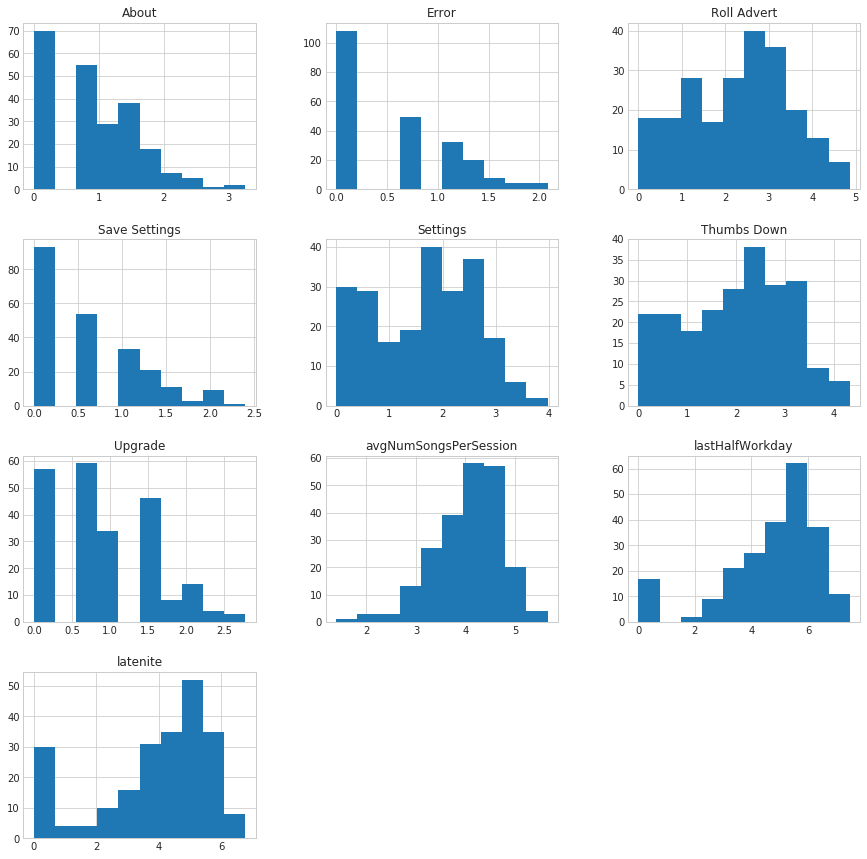

In [48]:
df[col_to_log] = np.log(df[col_to_log]+1)
df[col_to_log].hist(figsize=(15,15));

# 4. Modeling

We now have a set of features and labels ready to model.  We pool together all of the code from above here for scalability and ease of execution.

## 4a. Input and Clean Data

In [49]:
df = spark.read.json(sparkify_data)
df.persist()

# Drop empty columns
df = df.where(F.col('userId') != "")

# Change the date columns to a timestamp format and create user duration measurements.
df = df.withColumn('registration', F.to_timestamp(F.col('registration')/1000))\
  .withColumn('ts', F.to_timestamp(F.col('ts')/1000))\
  .withColumn('userDurationInHours', (F.col('ts').cast('long') - F.col('registration').cast('long'))/3600)

hour = F.udf(lambda x: x.hour, IntegerType())
df = df.withColumn('timeOfDay', 
                         F.when((hour(F.col('ts')) >= 1) & (hour(F.col('ts')) <= 7), 'earlyMorning')\
                        .otherwise(F.when((hour(F.col('ts')) >= 8) & (hour(F.col('ts')) <= 13), 'firstHalfWorkday')\
                        .otherwise(F.when((hour(F.col('ts')) >= 14) & (hour(F.col('ts')) <= 18), 'lastHalfWorkday')\
                        .otherwise(F.when((hour(F.col('ts')) >= 19) & (hour(F.col('ts')) <= 21), 'evening')\
                        .otherwise('latenite'))))
                  )

# Increment each cancellation event by 1 second to assure there's no matching timestamp with any other events 
# and that the cancellation step is the user's final step.
df = df.withColumn('ts', F.when(F.col('page') == 'Cancellation Confirmation',\
            F.col('ts') + F.expr('INTERVAL 1 seconds')).otherwise(F.col('ts')))

# Drop columns determined by exploration analysis above.
df = df.drop('firstName', 'lastName', 'location', 'userAgent', 'auth', 'method', 'length', 'registration')

# Churn will be defined as when the user submits a cancellation confirmation.
flag_churn_event = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churnEvent', flag_churn_event(F.col('page')))

window = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.currentRow)
df = df.withColumn('churnPhase', F.sum('churnEvent').over(window))

df_labels = df.groupBy('userId').agg(F.max('churnEvent').alias('customerChurnLabel'))

# Split the data into phases defined by churn event, 
# only analyze "before" events so to create a predictive model of customer churn.
df = df.filter(F.col('churnPhase') == 0).drop('churnPhase','churnEvent')

## 4b. Feature Engineering

In [50]:
# Aggregate functions
df_input_base = df.groupBy(F.col('userId')).agg(
        F.max(F.when(F.col('gender') == 'M', 1).otherwise(0)).alias('isMale'),
        F.sum(F.when(F.col('status') == '404', 1).otherwise(0)).cast('integer').alias('brokenPageViewCount'),
        F.max(F.round(F.col('userDurationInHours')).cast('integer')).alias('hoursSinceRegistration'),
        F.countDistinct(F.col('artist')).cast('integer').alias('distinctArtists'),
        F.countDistinct(F.col('song')).cast('integer').alias('distinctSongs')
    )

# Last seen user level
df_level = df.select(F.col('userId'), F.col('ts'), F.col('level'))
user_final_level = F.udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df_level = df_level.withColumn('level', user_final_level('level').cast(IntegerType()))

w = Window.partitionBy('userId').orderBy(F.desc('ts'))
df_level = df_level.withColumn('timeRankDesc', F.row_number().over(w))
df_level = df_level.filter(F.col('timeRankDesc') == 1).drop('timeRankDesc', 'ts')

# Average Items, Length per Session, & Number of Songs per Session
df_items_len_per_session = df.groupBy(F.col('userId'), F.col('sessionId'))\
    .agg(F.max(F.col('itemInSession')).alias('itemsPerSession'),
        ((F.max(F.col('ts').cast('long')) - F.min(F.col('ts').cast('long'))) / 3600).alias('hoursPerSession'),
        F.sum(F.when(F.col('page') == 'NextSong', 1).otherwise(0)).alias('numSongsPerSession'))\
    .groupBy(F.col('userId'))\
    .agg(F.mean(F.round(F.col('itemsPerSession'))).cast('integer').alias('avgItemsPerSession'),
        F.mean(F.round(F.col('hoursPerSession'))).cast('integer').alias('avgHoursPerSession'),
        F.mean(F.round(F.col('numSongsPerSession'))).cast('integer').alias('avgNumSongsPerSession')
        )

# Page views
df_page_views = df.filter(~F.col('page').isin(['Cancellation Confirmation']))\
    .groupBy(F.col('userId'))\
    .pivot('page')\
    .agg(F.count(F.col('page')).cast('integer'))\
    .na.fill(value=0)

# Time of day
df_time_of_day = df.filter(F.col('page').isin(['NextSong']))\
    .groupBy(F.col('userId'))\
    .pivot('timeOfDay')\
    .agg(F.count(F.col('page')).cast('integer').alias('pageVisits'))\
    .na.fill(value=0)

# Joins
df_input = df_input_base.join(df_level, ['userId'])\
        .join(df_items_len_per_session, ['userId'])\
        .join(df_page_views, ['userId'])\
        .join(df_time_of_day, ['userId'])\
        .join(df_labels, ['userId'])

In [51]:
# Adjust for high collinearity
# from analysis for collinearity above:
cols_to_keep = ['userId', 'isMale', 'hoursSinceRegistration', 'level', 'avgNumSongsPerSession', 'About', 'Error', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Upgrade', 'lastHalfWorkday', 'latenite', 'customerChurnLabel']
df_input = df_input.select(cols_to_keep)

In [52]:
# Adjust skew on columns. Drop binary features, close to binary features, and those without much skew
exclude_cols = ['customerChurnLabel','userId','isMale','level', 'Cancel', 
                'Submit Downgrade', 'Submit Upgrade', 'hoursSinceRegistration']
col_to_log = [col for col in df_input.columns if col not in exclude_cols]
df_input = df_input.select(*[F.log(F.col(col) + 1).alias(col) if col in col_to_log else col for col in df_input.columns])

## 4.3 Train-Test Split

In [53]:
df_input = df_input.withColumn('label', df_input['customerChurnLabel'].cast('float')).drop('customerChurnLabel')
input_cols = df_input.drop('label').drop('userId').columns
train, test = df_input.randomSplit([0.8, 0.2], seed=42)

## 4.4 Evaluation Metric

I'll choose to use an F1 metric to evaluate the success of this model since the data labels are imbalanced (roughly 70% - 30% unchurned vs. churned).  Using purely accuracy will automatically yield high results even on a naive model since most labels are unchurned.  The F1 score which is a balanced score between precision and recall.

## 4.5 Helper Functions

Framework for model pipeline, training, performance evaluation.  `MaxAbsScaler` chosen for scaling to preserve data shape from bias adjustment.

In [54]:
def build_pipeline(classifier, input_cols=input_cols):
    '''
    Build ML pipeline
    
    INPUT
    classifier: ML classifier
    param_grid: param grid
    
    OUTPUT
    pipeline: ml pipeline to build model & transform data
    '''
    # Configure an ML pipeline
    assembler = VectorAssembler(inputCols=input_cols, outputCol='inputRawFeatures')
    scaler = MaxAbsScaler(inputCol='inputRawFeatures', outputCol='inputFeatures')
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    return pipeline

In [55]:
def train_model(model, param_grid, train):
    '''
    Train ML model
    
    INPUT
    model: ML model
    param_grid: param grid
    train: training data
    
    OUTPUT
    fitted_pipeline: a fitted pipeline with model using cross validator
    training time: time it took to train the model
    '''
    pipeline = build_pipeline(model)
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param_grid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3
    )    
    start = time()
    fitted_pipeline = cv.fit(train)
    end = time()    
    training_time = end - start
    
    return fitted_pipeline, training_time

In [56]:
def evaluate_model(fitted_pipeline, train, test):
    '''
    Evaluate ML model
    
    INPUT
    fitted_pipeline: a fitted pipeline with model using cross validator
    train: training data
    test: test data
    
    OUTPUT
    f1_score_tr: F1 metric for training data
    f1_score_te: F1 metric for test data
    '''
    predicted_tr = fitted_pipeline.transform(train)
    predicted_te = fitted_pipeline.transform(test)
    
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
    
    f1_score_tr = round(evaluator.evaluate(predicted_tr),4)
    f1_score_te = round(evaluator.evaluate(predicted_te),4)
    
    return f1_score_tr, f1_score_te

In [57]:
def plot_feature_importance(model, input_cols):
    '''
    Plot Feature Importance
    
    INPUT
    model: ML model
    input_cols: list of input columns
    
    OUTPUT
    None
    '''
    feature_names = [input_cols[ind] for ind in model.featureImportances.indices.tolist()]
    features = model.featureImportances.values.tolist()
    features_df = pd.DataFrame(list(zip(feature_names, features)), 
           columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

    plt.figure(figsize=(15,5))
    sns.barplot(x='Feature', y='Importance', data=features_df)
    plt.title('Feature Importance', fontsize=14)
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12);

## 4.6 Initial Model Evaluation

Using default hyperparameters we'll compare the results of different models.

### Base Model
Naive model looking at if every customer was predicted to stay.  This model will be used as a baseline for measuring success of other models.

In [58]:
base_model_pred = df_input.select('label').withColumn('prediction', F.lit(0.0))
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
f1_score = round(evaluator.evaluate(base_model_pred), 4)
print('Naive model F1 Score: {}'.format(f1_score))

Naive model F1 Score: 0.6684


### Logistic Regression

In [59]:
fname_pipeline = 'logistic_pipeline'
fname_model = 'logistic_model'
if Path(fname_pipeline).exists() and Path(fname_model).exists():
    fitted_pipeline = PipelineModel.load(fname_pipeline)
    training_time = 0
else:
    model = LogisticRegression(maxIter=1, labelCol='label', featuresCol='inputFeatures')
    param_grid = ParamGridBuilder().build()
    fitted_pipeline, training_time = train_model(model, param_grid, train)
    
f1_score_tr, f1_score_te = evaluate_model(fitted_pipeline, train, test)

if not(Path(fname_pipeline).exists() or Path(fname_model).exists()):
    bestPipeline = fitted_pipeline.bestModel
    bestPipeline.save(fname_pipeline)
    bestModel = bestPipeline.stages[2] # stage 2 is actual model
    bestModel.save(fname_model)

print('Logistic Regression, Training Time: {}min, F1 Score (Train): {}, F1 Score (Test): {}'\
      .format(round(training_time/60,0), f1_score_tr, f1_score_te))

Logistic Regression, Training Time: 0.0min, F1 Score (Train): 0.6694, F1 Score (Test): 0.6627


### Gradient Boosting

In [60]:
fname_pipeline = 'xgb_pipeline'
fname_model = 'xgb_model'
if Path(fname_pipeline).exists() and Path(fname_model).exists():
    fitted_pipeline = PipelineModel.load(fname_pipeline)
    training_time = 0
else:
    model = GBTClassifier(maxIter=1, labelCol='label', featuresCol='inputFeatures')
    param_grid = ParamGridBuilder().build()
    fitted_pipeline, training_time = train_model(model, param_grid, train)
    
f1_score_tr, f1_score_te = evaluate_model(fitted_pipeline, train, test)

if not(Path(fname_pipeline).exists() or Path(fname_model).exists()):
    bestPipeline = fitted_pipeline.bestModel
    bestPipeline.save(fname_pipeline)
    bestModel = bestPipeline.stages[2] # stage 2 is actual model
    bestModel.save(fname_model)

print('XGBoost, Training Time: {}min, F1 Score (Train): {}, F1 Score (Test): {}'\
      .format(round(training_time/60,0), f1_score_tr, f1_score_te))

XGBoost, Training Time: 0.0min, F1 Score (Train): 0.9232, F1 Score (Test): 0.776


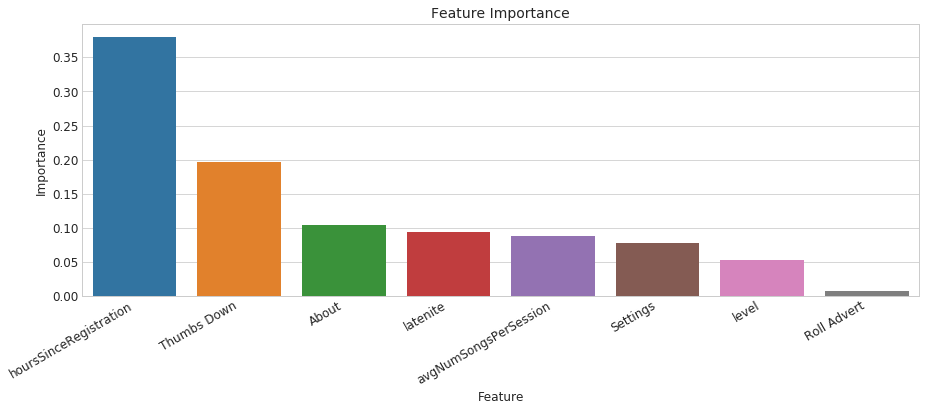

In [61]:
bestGBTModel = GBTClassificationModel.load(fname_model)
plot_feature_importance(bestGBTModel, input_cols)

In [66]:
!rm -R 'forest_pipeline'
!rm -R 'forest_model'
!rm -R 'tuned_forest_pipeline'
!rm -R 'tuned_forest_model'

### Random Forest

In [67]:
fname_pipeline = 'forest_pipeline'
fname_model = 'forest_model'
if Path(fname_pipeline).exists() and Path(fname_model).exists():
    fitted_pipeline = PipelineModel.load(fname_pipeline)
    training_time = 0
else:
    model = RandomForestClassifier(labelCol='label', featuresCol='inputFeatures', numTrees=5, maxDepth=5)
    param_grid = ParamGridBuilder().build()
    fitted_pipeline, training_time = train_model(model, param_grid, train)
    
f1_score_tr, f1_score_te = evaluate_model(fitted_pipeline, train, test)

if not(Path(fname_pipeline).exists() or Path(fname_model).exists()):
    bestPipeline = fitted_pipeline.bestModel
    bestPipeline.save(fname_pipeline)
    bestModel = bestPipeline.stages[2] # stage 2 is actual model
    bestModel.save(fname_model)

print('Random Forest, Training Time: {}min, F1 Score (Train): {}, F1 Score (Test): {}'\
      .format(round(training_time/60,0), f1_score_tr, f1_score_te))

Random Forest, Training Time: 11.0min, F1 Score (Train): 0.8647, F1 Score (Test): 0.826


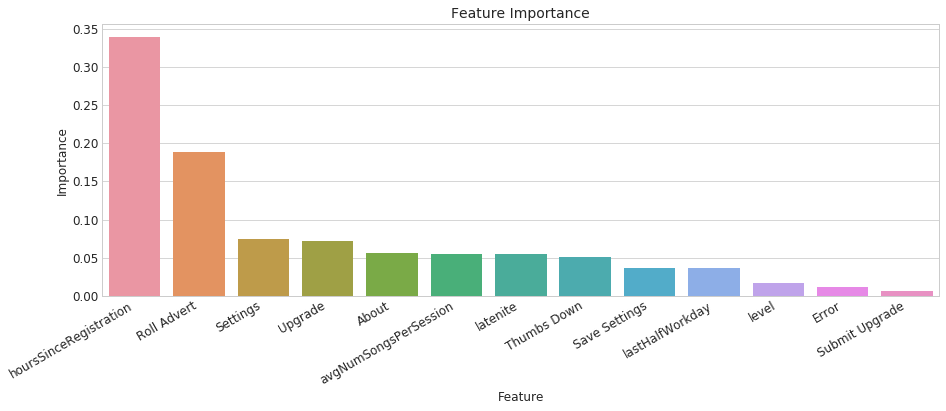

In [68]:
bestForestModel = RandomForestClassificationModel.load(fname_model)
plot_feature_importance(bestForestModel, input_cols)

### Summary

The results of all the models (without tuning hyperparameters) is shown below:

| Model               | Training Time | F1 Score Train | F1 Score Test  |
| -----------         | -----------   | -----------    | -----------    |
| Naive               | 0.0 min       | overall: 0.6684| overall: 0.6684|
| Logistic Regression | 10.0 min      | 0.6694         | 0.6627         |
| Gradient Boosting   | 29.0 min      | 0.9232         | 0.7760         |
| Random Forest       | 11.0 min      | 0.8647         | 0.8260         |

The Naive model, used as a base measurement for this experiment, has an overall F1 Score of `0.6684`.  The logistic regression model, without hyperparameter tuning, slightly under-performs the base on the test set with F1 = `0.6627`, we will not consider this model for further use.  Gradient Boosting, on the other hand, had a test F1 score of `0.7760`, ~11% higher than the base.  Unfortunately, the model in this instance was stripped down to it's minimum performance and still had a training F1 of `0.8400`, indicating higher variance in it's performance. We believe the model could overfit the training data if boosted slightly more.  Random forest showed both `0.8647` and `0.8260` for F1 training & test sets, respectively.  This model shows the highest test F1, with the lowest bias/variance, and it ran reasonably fast at `11.0 min`, better than XBG at `29.0 min`.  For these reasons we'll continue to fine tune the Random Forest Model.

## 4.7 Hyperparameter Tuning

We're going to tune the hyperparameters of random forest.  Specifically we'll look at `numTrees` and `maxDepth`.  `numTrees` is thought to be the most important setting for random forest as it increases/decreases the number of decision trees used to predict variable outcome.  We want to keep a lower tree count for computational complexity but not too low as to introduce unneccessary bias.  `maxDepth` sets the max level in each decision tree.  Again, we'd like to keep this to a minimum to prevent high variance & reduce computational complexity.  Below we'll try configurations that keep the `maxDepth` low but experiment with relatively smaller to medium size forests.

In [69]:
fname_pipeline = 'tuned_forest_pipeline'
fname_model = 'tuned_forest_model'
if Path(fname_pipeline).exists() and Path(fname_model).exists():
    fitted_pipeline = PipelineModel.load(fname_pipeline)
    training_time = 0
else:
    model = RandomForestClassifier(labelCol='label', featuresCol='inputFeatures')
    param_grid = ParamGridBuilder()\
        .addGrid(model.numTrees, [20, 40, 50]) \
        .addGrid(model.maxDepth, [10, 15, 20])\
        .build()
    fitted_pipeline, training_time = train_model(model, param_grid, train)
    
f1_score_tr, f1_score_te = evaluate_model(fitted_pipeline, train, test)

if not(Path(fname_pipeline).exists() or Path(fname_model).exists()):
    bestPipeline = fitted_pipeline.bestModel
    bestPipeline.save(fname_pipeline)
    bestModel = bestPipeline.stages[2] # stage 2 is actual model
    bestModel.save(fname_model)

print('Random Forest, Training Time: {}min, F1 Score (Train): {}, F1 Score (Test): {}'\
      .format(round(training_time/60,0), f1_score_tr, f1_score_te))

Random Forest, Training Time: 50.0min, F1 Score (Train): 0.9894, F1 Score (Test): 0.8669


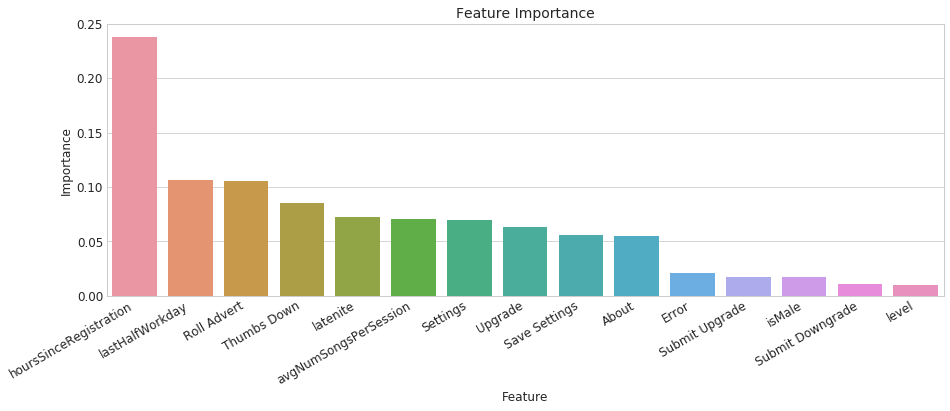

In [70]:
bestForestModel = RandomForestClassificationModel.load(fname_model)
plot_feature_importance(bestForestModel, input_cols)

**Final solution:** tuned random forest with training F1 score = `0.9894`, testing F1 Score = `0.8669`.  This is slighlty high variance to what would be expected but for such a small dataset it is acceptable.  Test performance significantly better than naive model, showing this would be model beneficial in a professional scenario.  More training data can remedy the issue.  Feature importance for the tuned random forest differs from the original random forest and XGB.  While all 3 algorithms put most focus into `hoursSinceRegistration`, the final model focused on `lastHalfWorkday`, `Roll Advert` & the next 5 features.  It's believed that the bagging used by the random forest, of relatively shallow trees, prevented massive overfitting seen by the gradient boosting model but provided a more robust approach than vanilla logistic regression, leading to good overall performance on both the training and test sets.    

# 5. Conclusion

A tuned random forest model was used on aggregated user input data to predict customer churn and performed well above other models.  A difficulty we faced in this analysis was narrowing our search of aggregation metrics down to somehting reasonable for input data.  We could have analyzed every combination of input data but had to limit it to the most impactful features which needed a great combination of analysis and subject matter expertise.

This model could have been imporved if we did not aggregate the data rather used a more sophisticated approach to not lose the time series aspects of the data.  We believe that the best indicator of churn is a `change` in user behaviour over time, which is hard to capture in 1 row aggregates.  In the future these time series models can be further explored.